<a href="https://colab.research.google.com/github/glorivaas/Machine_Learning25/blob/main/Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4 - Penalized Regression

### Author: Gloria Rivas Nóvoa
<br>

**Analyzing and Plotting Bias in Penalized Regression**

___
**How does varying the regularization parameter $\lambda$ in Ridge and Lasso regression impact the trade-off between bias and variance?**
<br>First, we generate a synthetic dataset based on a known linear relationship, as requested.

In [1]:
import numpy as np
import pandas as pd

np.random.seed(42)

n_samples = 100
n_features = 50

X = np.random.randn(n_samples, n_features)

true_beta = np.zeros(n_features)
non_zero_indices = np.random.choice(n_features, size=5, replace=False)
true_beta[non_zero_indices] = np.random.uniform(-2, 2, size=5)

sigma_squared = 2.0
sigma = np.sqrt(sigma_squared)

epsilon = np.random.normal(0, sigma, n_samples)

y = X @ true_beta + epsilon

df = pd.DataFrame(X, columns=[f'X{i+1}' for i in range(n_features)])
df['y'] = y

print(df.head())

print("\nTrue Coefficients (mostly zeros, a few non-zero):")
print(true_beta)
print(f"\nNoise standard deviation (σ): {sigma:.2f}, Variance (σ²): {sigma_squared:.2f}")


         X1        X2        X3        X4        X5        X6        X7  \
0  0.496714 -0.138264  0.647689  1.523030 -0.234153 -0.234137  1.579213   
1  0.324084 -0.385082 -0.676922  0.611676  1.031000  0.931280 -0.839218   
2 -1.415371 -0.420645 -0.342715 -0.802277 -0.161286  0.404051  1.886186   
3  0.250493  0.346448 -0.680025  0.232254  0.293072 -0.714351  1.865775   
4  0.357787  0.560785  1.083051  1.053802 -1.377669 -0.937825  0.515035   

         X8        X9       X10  ...       X42       X43       X44       X45  \
0  0.767435 -0.469474  0.542560  ...  0.171368 -0.115648 -0.301104 -1.478522   
1 -0.309212  0.331263  0.975545  ...  0.968645 -0.702053 -0.327662 -0.392108   
2  0.174578  0.257550 -0.074446  ...  1.307143 -1.607483  0.184634  0.259883   
3  0.473833 -1.191303  0.656554  ...  0.856399  0.214094 -1.245739  0.173181   
4  0.513786  0.515048  3.852731  ... -0.114736  0.504987  0.865755 -1.200296   

        X46       X47       X48       X49       X50         y  
0 -0

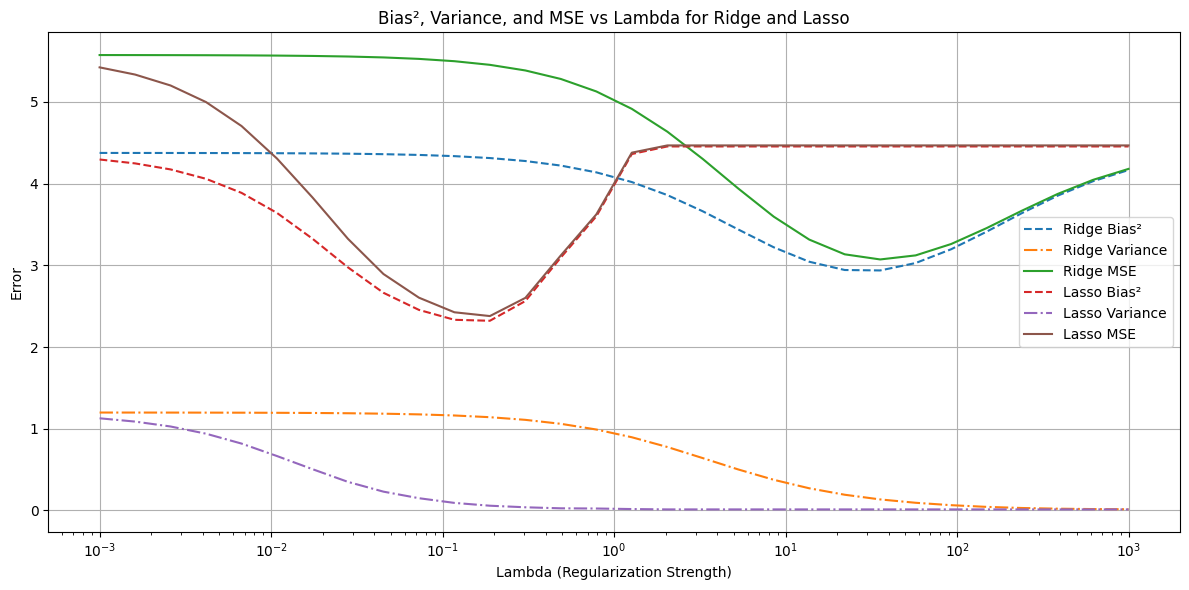

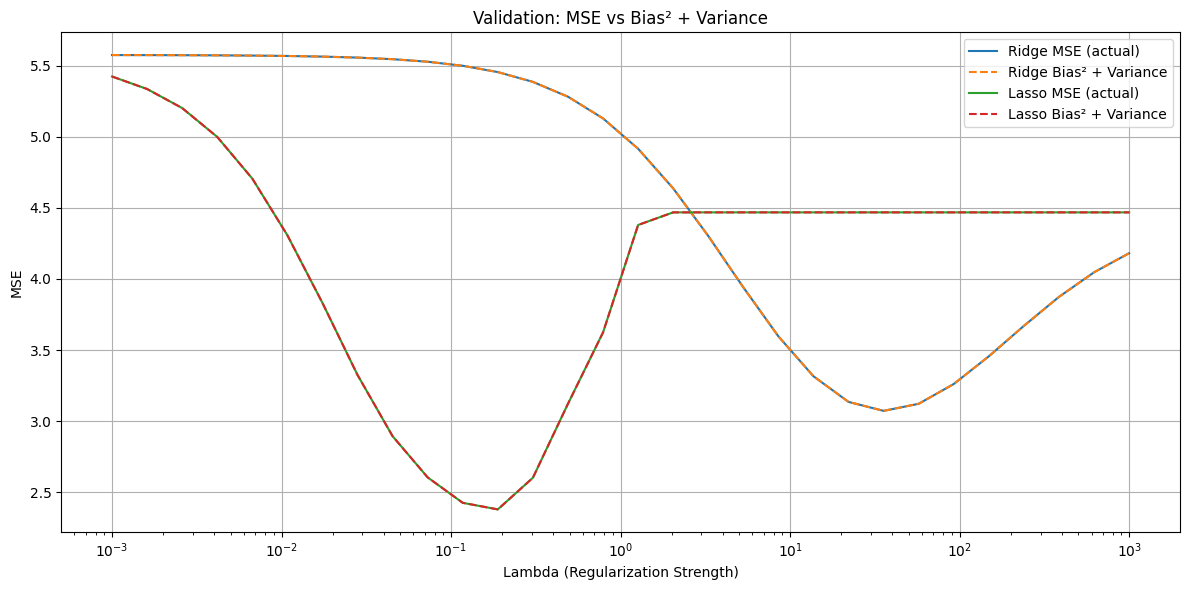

In [8]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from collections import defaultdict

lambda_values = np.logspace(-3, 3, 30)
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

ridge_bias2, ridge_variance, ridge_mse = [], [], []
lasso_bias2, lasso_variance, lasso_mse = [], [], []

for alpha in lambda_values:

    ridge_preds_by_index = defaultdict(list)
    lasso_preds_by_index = defaultdict(list)
    y_true_dict = {}

    for train_index, test_index in rkf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        ridge = Ridge(alpha=alpha).fit(X_train, y_train)
        lasso = Lasso(alpha=alpha, max_iter=10000).fit(X_train, y_train)

        ridge_pred = ridge.predict(X_test)
        lasso_pred = lasso.predict(X_test)

        for idx, i in enumerate(test_index):
            ridge_preds_by_index[i].append(ridge_pred[idx])
            lasso_preds_by_index[i].append(lasso_pred[idx])
            y_true_dict[i] = y_test[idx]

    indices = sorted(y_true_dict.keys())

    ridge_bias2.append(np.mean([(np.mean(ridge_preds_by_index[i]) - y_true_dict[i]) ** 2 for i in indices]))
    lasso_bias2.append(np.mean([(np.mean(lasso_preds_by_index[i]) - y_true_dict[i]) ** 2 for i in indices]))

    ridge_variance.append(np.mean([np.var(ridge_preds_by_index[i]) for i in indices]))
    lasso_variance.append(np.mean([np.var(lasso_preds_by_index[i]) for i in indices]))

    ridge_mse.append(np.mean([(pred - y_true_dict[i]) ** 2 for i in indices for pred in ridge_preds_by_index[i]]))
    lasso_mse.append(np.mean([(pred - y_true_dict[i]) ** 2 for i in indices for pred in lasso_preds_by_index[i]]))

plt.figure(figsize=(12, 6))

plt.semilogx(lambda_values, ridge_bias2, label='Ridge Bias²', linestyle='--')
plt.semilogx(lambda_values, ridge_variance, label='Ridge Variance', linestyle='-.')
plt.semilogx(lambda_values, ridge_mse, label='Ridge MSE', linestyle='-')

plt.semilogx(lambda_values, lasso_bias2, label='Lasso Bias²', linestyle='--')
plt.semilogx(lambda_values, lasso_variance, label='Lasso Variance', linestyle='-.')
plt.semilogx(lambda_values, lasso_mse, label='Lasso MSE', linestyle='-')

plt.xlabel("Lambda (Regularization Strength)")
plt.ylabel("Error")
plt.title("Bias², Variance, and MSE vs Lambda for Ridge and Lasso")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Validation plot
ridge_mse_theory = np.array(ridge_bias2) + np.array(ridge_variance)
lasso_mse_theory = np.array(lasso_bias2) + np.array(lasso_variance)

plt.figure(figsize=(12, 6))
plt.semilogx(lambda_values, ridge_mse, label='Ridge MSE (actual)', linestyle='-')
plt.semilogx(lambda_values, ridge_mse_theory, label='Ridge Bias² + Variance', linestyle='--')

plt.semilogx(lambda_values, lasso_mse, label='Lasso MSE (actual)', linestyle='-')
plt.semilogx(lambda_values, lasso_mse_theory, label='Lasso Bias² + Variance', linestyle='--')

plt.xlabel("Lambda (Regularization Strength)")
plt.ylabel("MSE")
plt.title("Validation: MSE vs Bias² + Variance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##**MSE decomposition into bias and variance.**
The Mean Squared Error (MSE) is a common metric used to evaluate the performance of a model. For a prediction function $\hat{f}(x)$ and true output $y$, the MSE is defined as:

$$
\text{MSE}(x) = \mathbb{E}\left[ (y - \hat{f}(x))^2 \right]
$$

Assume that the true relationship between the input and output is given by:

$$
y = f(x) + \varepsilon
$$

where $f(x)$ is the true function, $\varepsilon$ is the irreducible noise with mean $0$ and variance $\sigma^2$.
We can decompose the MSE into $bias^2$, $variance$ and $error$.
$$\text{MSE}(x) = \underbrace{\left( \mathbb{E}[\hat{f}(x)] - f(x) \right)^2}_{\text{Bias}^2} + \underbrace{\mathbb{E} \left[ (\hat{f}(x) - \mathbb{E}[\hat{f}(x)])^2 \right]}_{\text{Variance}} + \underbrace{\sigma^2}_{\text{Irreducible Error}}
$$

Let´s now analyze our plot.

<br>First, regarding **Ridge Regression**, we can observe that $bias^2$ starts moderately high, only to have a slight dip and then increase gradually as λ increases. It does not show great changes as Ridge never zeroes out features, so it keeps some capacity to fit the data.
<br>On the other hand, $variance$ starts higher than in Lasso and decreases gradually with increasing λ, as expected.
<br>Hence, we can interpret that this method prefers smooth shrinkage over hard sparsity.

</n>In **Lasso**'s plot we see that $Bias^²$ starts lower than Ridge, drops at first, then rises sharply beyond λ ≈ 0.5. This is due to the fact that this methods zeroes out coefficients, losing flexibility and underfitting when increasing λ.
<br> If we focus in the $variance$, it starts slightly lower than Ridge and drops quickly. In fact, it becomes almost zero at high λ, beacuse it becomes highly stable once it forces many coefficients to zero.
<br> From this we can conclude that Lasso is more aggressive (it heavily penalizes features and often zeros out irrelevant ones, creating sparse models). This is penalized in an increaing bias when λ is large but gives big variance gains.

##**When should we choose each method?**
1. Use Lasso in cases when:
 - Feature sparsity exists i.e., only a few features matter. This method will help reducing noise and improving generalization.

 - For high-dimensional datasets, where you want to identify which features matter.

 - You need lower variance. Lasso will perform better by aggressively simplifying the model.

2. Choose Ridge When:
 - Multicollinearity is present. If features are highly correlated, this method handles this better by shrinking coefficients together rather than eliminating them.
 - Most features are useful (non-sparse). Ridge performs better by keeping all variables with smaller weights.
 - You do not want a high bias, as Ridge typically results in lower values than Lasso at high λ because it does not completely zero out features.

##**Does the regularization lead to an optimal trade-off point where MSE is minimized?**
Yes, it does. Regularization (like in Ridge or Lasso) introduces a penalty term that controls model complexity. This changes the balance between variance and bias. As we have seen, variance decreases due to the fact that tmodel becomes simpler, less sensitive to noise in training data and bias increases as the model becomes too simple to capture patterns (underfitting). As a result, MSE shows a U-shape; first decreases, reaches a minimum and then increases again. Therefore, there is an optimal regularization lambda where MSE is minimized.

